<a href="https://colab.research.google.com/github/mdelrosa/eec206-lab1/blob/master/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EEC206: Lab #1
**Group 2: Neil Arakkal, Mason del Rosario**

Notebook for [Lab #1](https://canvas.ucdavis.edu/courses/442005/assignments/453054), image component clustering algorithm. From the assignment statement,

> For this assignment, write a simple python function out_img, n = ccGroup(in_img) where in_img is a grayscale image (255 is considered to be white and all other levels are considered to be black), n is the number of clusters, and out_img is a grayscale image with different objects at different well-separated gray levels.





## Step 0: Import needed routines


In [0]:
# for inline image display inside notebook
# % matplotlib inline 
import numpy as np
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
import time

## Step 1: Define classes for image loading, segmentation, and timing


### `Timer`
Keeps track of runtimes for processing each segment in the algorithm


In [0]:
# timer class for timing projecting time-to-finish
class Timer(object):
    def __init__(self,name=None):
        self.name = name
        self.finished = 0
        self.times = []
    
    def __enter__(self):
        self.tstart = time.time()
    
    def __exit__(self, type, value, traceback):
        self.finished = self.finished + 1
        self.elapsed = time.time() - self.tstart
        self.times.append(self.elapsed)
        print('--- {} -> Time Elapsed: {:5.2f} seconds for {} segments ---'.format(self.name,np.sum(self.times),self.finished))
    
    def get_times(self):
        return self.times


### `ImageLoader`

Used to load, flatten, and describe a loaded image


In [0]:
class ImageLoader():
  def __init__(self,img_name):
    self.img_name = img_name 
    self.img = mpimg.imread(img_name)
    try:
      self.n_row, self.n_col, self.n_chan = self.img.shape
      thresh = 1 if self.n_chan == 4 else 255/8 # blobs image has grey vals
      self.flatten_img(thresh=thresh)
    except ValueError: # if number of channels not defined
      self.n_row, self.n_col = self.img.shape
      flat_img = np.zeros((self.n_row, self.n_col))
      for row in range(self.n_row):
        for col in range(self.n_col):
          val = self.img[row,col]
          flat_img[row,col] = 255 if val > 0 else 0
      self.img = flat_img

  def desc_img(self):
    """
    : Give some basic details about image
    """
    print("Image shape={} - Data Type={} - Image Obj Type={}".format(self.img.shape, self.img.dtype, type(self.img)))      # this image contains an α channel, hence num_channels= 4

  def flatten_img(self,thresh=1):
    """
    : Convert multi-channel image to greyscale
    """
    flat_img = np.zeros((self.n_row, self.n_col))
    for row in range(self.n_row):
      for col in range(self.n_col):
          val = self.img[row,col,0]
          flat_img[row,col] = 255 if val > thresh else 0
          # val = np.mean(self.img[row,col,:]) 
    self.img = flat_img

### `ImageSegmenter`
Performs image segmentation recursively.
  - `get_white_ind()` -> Find and store all `white_ind` (indices of white pixels)
  - `group_white_ind()` -> Recursively segment image into `n_groups`
    - Step 0: Initialize array `group_nums` as all-zeros. This keeps track of each white pixel's segment #
    - Step 1: For `pixel` in `white_ind`
      - If `group_num[pixel]` is 0
        - Increment `n_groups`
        - Set `group_num[pixel]=n_groups`
        - Call `check_neighbors(pixel)`
    - Step 2: Render `seg_img` using complete `group_num` list
    - Step 3: Return `seg_img`


The core of the segmentation algorithm is `check_neighbors`, which is inspired by the [Flood Fill algorithm](https://en.wikipedia.org/wiki/Flood_fill). The operating principle of Flood Fill is to pick a pixel, paint it a certain color, and continue painting adjacent unpainted pixels (illustration in the figure below).

<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/7/7e/Recursive_Flood_Fill_4_%28aka%29.gif">
</p>

In [0]:
class ImageSegmenter():
  def __init__(self,img):
    self.img = img
    self.n_row, self.n_col = self.img.shape
    self.timer = Timer("Segment Timer")

  def desc_img(self):
    """
    : Give some basic details about image
    """
    print("Image shape={} - Data Type={} - Image Obj Type={}".format(self.img.shape, self.img.dtype, type(self.img)))      # this image contains an α channel, hence num_channels= 4

  def plot_img(self,size=(10,10),plot_seg_bool=False):
    """
    : Plot target image with size option
    : Input image by default, segmented image if 
    """
    if plot_seg_bool:
      target = self.seg_img
    else:
      target = self.img
    plt.figure(figsize=(5,5))
    plt.imshow(target, cmap=cm.gray, vmin=0, vmax=255) # display the image
    plt.axis('off')
    plt.show()

  def segment_img(self):
    """
    : TO-DO: Perform image segmentation
    """
    self.get_white_ind()
    print("Number of pixels in segments: {}".format(len(self.white_ind)))
    self.group_white_ind()
    print("Number of segments: {}".format(self.n_groups))
    print("Average segment time: {:5.2f} seconds".format(np.mean(self.timer.times)))
    self.render_segmented_img()

  def get_white_ind(self):
    """
    : Get indices of all pixels in segments (i.e., white pixels)
    """
    self.white_ind = []
    for row in range(self.n_row):
      for col in range(self.n_col):
        if self.img[row,col]==255:
          self.white_ind.append((row,col))
    
  def group_white_ind(self):
    """
    : Group white pixels and assign group numbers
    """
    self.n_groups = 0
    self.group_nums = np.zeros(len(self.white_ind)) # keep track of group numbers for each white pixel
    for i in range(len(self.white_ind)):
      if (self.group_nums[i] == 0): 
        with self.timer:
          self.n_groups += 1 
          self.group_nums[i] = self.n_groups 
          self.check_neighbors(self.white_ind[i])

  def check_neighbors(self,pixel_ind):
    """
    : Recursively check 8-adjacent pixels within a segment
    """
    row, col = pixel_ind
    test_pixels = []
    for next_row in range(-1,2):
      for next_col in range(-1,2):
        if (not(next_row==0 and next_col==0)): # don't check current pixel
          test_pixels.append((row+next_row,col+next_col))
    test_indices = [white_index for white_index, white_pix in enumerate(self.white_ind) if white_pix in test_pixels]
    for white_index in test_indices:
      if self.group_nums[white_index] == 0: # if adjacent pixel is 0, we set it and check its neighbors
        self.group_nums[white_index] = self.n_groups
        self.check_neighbors(self.white_ind[white_index])  

  def render_segmented_img(self):
    """
    : Given white pixel indices and group numbers, construct np array for 
    : segmented image
    """
    self.seg_img = np.zeros((self.n_row,self.n_col))
    divs = self.n_groups+1 # we want (# of segments+1) color divisions including black
    for i in range(len(self.white_ind)):
      white_row, white_col = self.white_ind[i]
      self.seg_img[white_row, white_col] = int(255*(divs-self.group_nums[i])/divs)

## Step 2: Define function wrapper to call class

Lab calls for `function out_img, n = ccGroup(in_img)`, so have `ccGroup` call the `ImageSegmenter` class.

In [0]:
def ccGroup(in_img):
  img_segmenter = ImageSegmenter(in_img)
  img_segmenter.desc_img()
  img_segmenter.plot_img() # plot input imagefhcfhc
  img_segmenter.segment_img()
  img_segmenter.plot_img(plot_seg_bool=True) # plot segmented image
  return img_segmenter.seg_img, img_segmenter.n_groups

## Step 3: Load, flatten, and segment image

**Validated images**
- [B+W Crosses](https://canvas.ucdavis.edu/courses/442005/files?preview=8295370)
- [Shapes](https://clouard.users.greyc.fr/Pantheon/experiments/morphology/fillholebin.png)
  - Initially resulted in `Recursion Error`. Works after `sys.setrecursionlimit(10**6)` call before `ccGroup()`.
- [Blobs (Takes a while)](https://imagejdocu.tudor.lu/_media/plugin/segmentation/thresholding_by_connection/blobs_connected.jpeg?cache=)
  - Image had grey values instead of strictly black/white. Required adding a `threshold` to the `ImageLoader.flatten()` method.

**Unvalidated images**
- [Cells](https://answers.opencv.org/upfiles/14295789404341916.jpg)
  - Larger image (1040, 1388). Timeout after ~20 minutes.

In [0]:
from google.colab import files
np.set_printoptions(threshold=sys.maxsize)
uploaded = files.upload()
for key, value in uploaded.items():
  img_name = key  
img_loader = ImageLoader(img_name)

Saving proj1-bw.gif to proj1-bw (6).gif


Image shape=(256, 256) - Data Type=float64 - Image Obj Type=<class 'numpy.ndarray'>


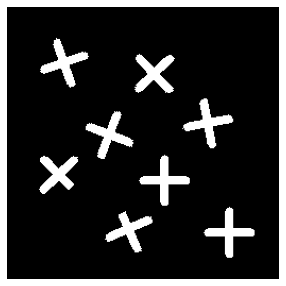

Number of pixels in segments: 5255
--- Segment Timer -> Time Elapsed:  0.82 seconds for 1 segments ---
--- Segment Timer -> Time Elapsed:  1.63 seconds for 2 segments ---
--- Segment Timer -> Time Elapsed:  2.45 seconds for 3 segments ---
--- Segment Timer -> Time Elapsed:  3.25 seconds for 4 segments ---
--- Segment Timer -> Time Elapsed:  4.05 seconds for 5 segments ---
--- Segment Timer -> Time Elapsed:  4.78 seconds for 6 segments ---
--- Segment Timer -> Time Elapsed:  5.57 seconds for 7 segments ---
--- Segment Timer -> Time Elapsed:  6.31 seconds for 8 segments ---
Number of segments: 8
Average segment time:  0.79 seconds


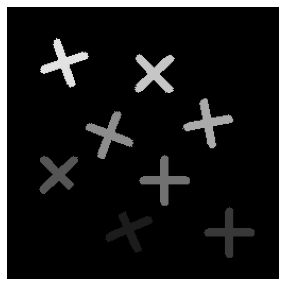

In [0]:
sys.setrecursionlimit(10**6) # increase allowable recursion depth
out_img, n = ccGroup(img_loader.img)

## Results

| Image       | Total Time    | Avg. Segment Time    | # Segments |
|:-----------:|:-------------:|:--------------------:|:----------:|
| B+W Crosses | 6.25s         | 0.78s                | 8          |
| Shapes      | 17.56s        | 2.20s                | 8          |
| Blobs       | 139.51s       | 2.01s                | 68         |


<p align="center">
  <img src="https://raw.githubusercontent.com/mdelrosa/eec206-lab1/master/images/final-seg.png">
</p>


